In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_colors
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors


In [2]:
import umap
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from src.file_locations import intermediate_files_location

print(f"sklearn version: {sklearn.__version__}")
print(f"umap version: {umap.__version__}")


sklearn version: 1.7.2
umap version: 0.5.9.post2


In [3]:
#training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"
#training = "first_mixed_del1g_iso_training"
training = "mixed_del1g_iso_training"

sig_category_name = "del1g_simple_signal_category"

if sig_category_name == "del1g_simple_signal_category":
    sig_categories = del1g_simple_category_labels
    sig_colors = del1g_simple_category_colors
elif sig_category_name == "del1g_detailed_signal_category":
    sig_categories = del1g_detailed_category_labels
    sig_colors = del1g_detailed_category_colors
elif sig_category_name == "topological_signal_category":
    sig_categories = topological_category_labels
    sig_colors = topological_category_colors
else:
    raise ValueError(f"Invalid sig_category_name: {sig_category_name}")


# File Loading

In [4]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(2801244, 249)
loading predictions.pkl...
pred_df.shape=(570053, 23)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(285027, 268)
presel_merged_df.shape=(285027, 268)


,wc_WCPMTInfoPePred,wc_single_photon_nue_score,wc_WCPMTInfoFlashTime,wc_shw_sp_n_20mev_showers,wc_WCPMTInfoClusterLength,wc_WCPMTInfoChi2,wc_WCPMTInfoStrength,wc_nc_delta_score,wc_nue_score,wc_WCPMTInfoFlashID,...,prob_numuCC1pi0_Np,prob_numuCC1pi0_0p,prob_1pi0_outFV,prob_nueCC_Np,prob_nueCC_0p,prob_multi_pi0,prob_eta_other,prob_0pi0,prob_other_outFV_dirt,prob_ext
7,NaN,-1.676819,NaN,1.0,NaN,NaN,NaN,-3.831858,-15.000000,NaN,...,0.000859,0.000748,0.030655,0.000031,8.675508e-07,0.000114,0.000002,0.039948,0.123368,0.302098
21,NaN,-1.911803,NaN,2.0,NaN,NaN,NaN,-2.425649,-4.049474,NaN,...,0.002029,0.000152,0.001397,0.000035,1.813454e-06,0.000054,0.000003,0.736630,0.012606,0.056006
71,NaN,-2.933243,NaN,1.0,NaN,NaN,NaN,-7.687320,-9.857704,NaN,...,0.017904,0.000331,0.000085,0.000052,3.244495e-06,0.000174,0.000020,0.819257,0.001148,0.001185
83,NaN,-0.845269,NaN,1.0,NaN,NaN,NaN,-7.675740,-9.418540,NaN,...,0.001431,0.000177,0.003851,0.000013,1.308034e-06,0.000047,0.000014,0.965934,0.002675,0.005351
97,NaN,-1.042449,NaN,2.0,NaN,NaN,NaN,-2.772756,-15.000000,NaN,...,0.011415,0.003482,0.051872,0.000125,1.455317e-06,0.000735,0.000002,0.219665,0.085948,0.154590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801224,"[218.02965708938942, 96.48310054519341, 247.52...",-0.121613,3.640625,2.0,26.643417,22.599668,0.900669,0.701968,-7.180203,11.0,...,0.000375,0.000440,0.025934,0.000025,1.024903e-06,0.000085,0.000032,0.012431,0.013040,0.110164
2801228,"[0.4558927557888138, 0.6679316830142493, 0.307...",0.335418,5.046875,1.0,18.046463,14.616974,0.899541,-3.961035,-5.085028,20.0,...,0.000203,0.000062,0.008907,0.000002,1.238782e-06,0.000012,0.000002,0.004214,0.002181,0.008957
2801235,"[3.938709237309973, 7.033329153876251, 2.75010...",-0.601346,4.218750,1.0,109.723200,143.050145,0.904547,-5.617090,2.522705,27.0,...,0.000028,0.000013,0.000010,0.000010,4.516321e-06,0.000005,0.000001,0.000006,0.000018,0.000012
2801242,"[10.249437394186069, 17.36728493156787, 6.9659...",-0.246698,4.687500,2.0,72.474578,42.130508,0.902401,-1.079290,-12.803833,11.0,...,0.000635,0.000346,0.000026,0.000002,2.361467e-05,0.000033,0.000104,0.000042,0.000031,0.000272


In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Probability Visualization

In [6]:
probs_scaled = probs_2d_arr

reducer = umap.UMAP()

reducer.fit(probs_scaled)
umap_result = reducer.transform(probs_scaled)


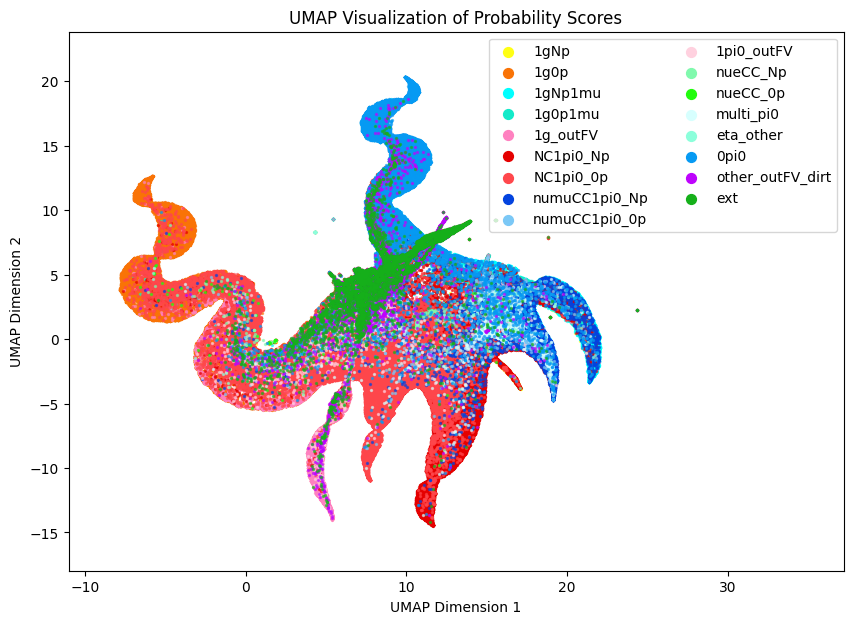

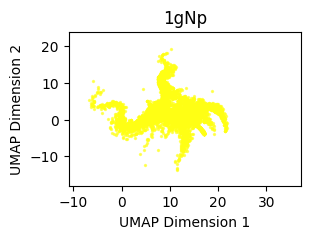

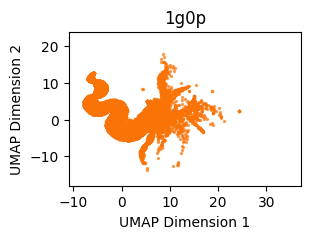

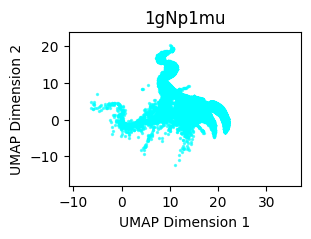

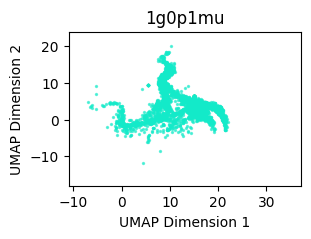

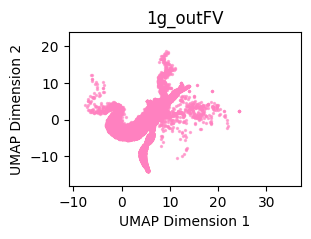

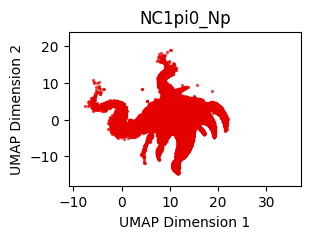

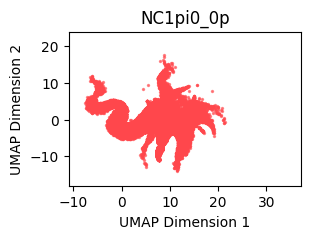

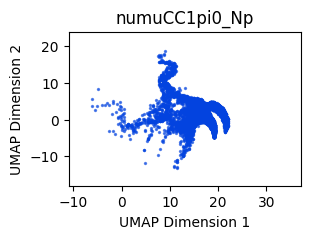

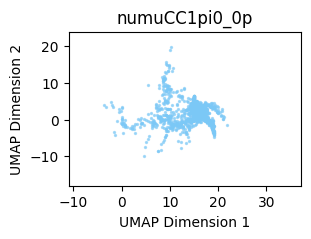

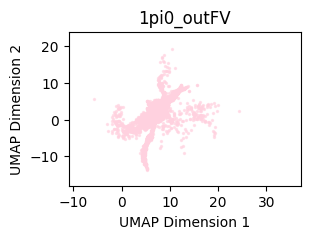

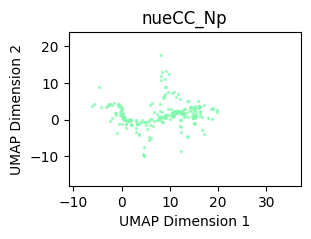

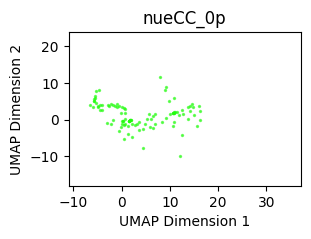

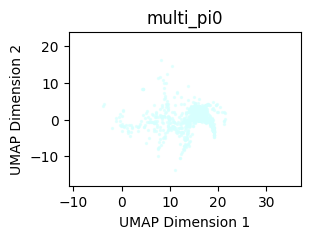

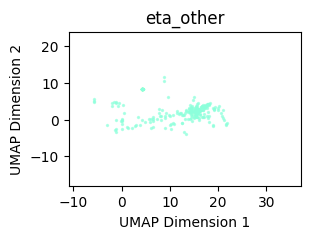

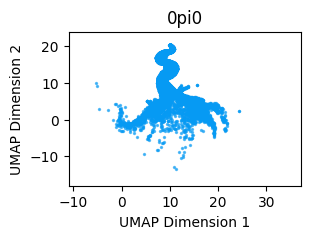

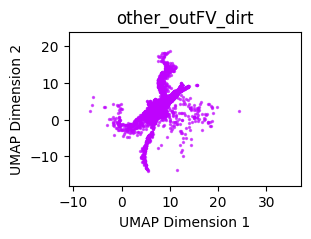

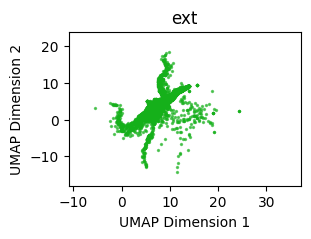

In [7]:
true_sig_categories = presel_merged_df[sig_category_name].to_numpy()
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=sig_colors[i])
    plt.scatter([], [], s=50, c=sig_colors[i], label=sig_categories[i])
plt.title('UMAP Visualization of Probability Scores')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/umap_visualization.png")

for i in range(len(sig_categories)):
    plt.figure(figsize=(3, 2))
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=sig_colors[i])
    plt.scatter([], [], s=50, c=sig_colors[i], label=sig_categories[i])
    plt.title(sig_categories[i])
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
    min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
    x_diff = max_x - min_x
    y_diff = max_y - min_y
    plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
    plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
    plt.savefig(f"../training_outputs/{training}/score_vis/{sig_categories[i]}_umap_visualization.png")
